In [1]:
from shapely import Point, MultiPoint, Polygon, LineString, GeometryCollection, box, affinity, ops

In [60]:
import matplotlib.patheffects as pe
import matplotlib.pyplot as plt
import numpy as np
import progressbar
import colorsys
import json
import csv

In [3]:
from dimensionality_reduction import reduce_dimensions
from tree import build_tree

In [4]:
EMBEDDINGS_FILE = 'embeddings.json'
REDUCED_FILE = 'reduced_embeddings_2d.csv'

In [5]:
with open(EMBEDDINGS_FILE,'r') as infile:
    data = json.load(infile)

In [6]:
embedding_labels = list(data.keys())
labels = [l[:-3] for l in embedding_labels] # get rid of '.md' file extension

In [7]:
embeddings = np.array([data[label] for label in embedding_labels])
latent_space = reduce_dimensions(embeddings,2)

In [8]:
color_space = reduce_dimensions(embeddings,2)
color_space = (color_space-np.min(color_space))/(np.max(color_space)-np.min(color_space))
color_space = [colorsys.hsv_to_rgb(vals[0], vals[1]/2, 0.85) for vals in color_space]

In [9]:
with open(REDUCED_FILE, 'w') as outfile:
    writer = csv.writer(outfile)
    writer.writerow(['x','y','filename'])
    for label, coords in zip(labels, latent_space):
        writer.writerow([coords[0],coords[1],label])

In [10]:
tree = build_tree(EMBEDDINGS_FILE)

In [11]:
tree.get_children()

594

In [12]:
def get_points(tree):
    points = np.empty((tree.get_children(),2))
    for i, filename in enumerate(tree.files):
        idx = embedding_labels.index(filename)
        points[i] = latent_space[idx]
    return points

In [13]:
def centroid(tree):
    return get_points(tree).mean(axis=0)

In [14]:
def balance(left, right):
    l_count = left.get_children()
    r_count = right.get_children()
    if l_count > r_count: comparison = 1-max(0.005, r_count/l_count)
    elif r_count > l_count: comparison = -(1-max(0.005, l_count/r_count))
    else: comparison = 0
    return comparison

In [15]:
points = MultiPoint(latent_space)

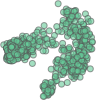

In [16]:
points

In [17]:
bounding_box = box(*points.bounds)
bounding_box = affinity.scale(bounding_box, xfact=1.2, yfact=1.2)

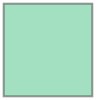

In [18]:
bounding_box

In [19]:
bx, by = bounding_box.exterior.coords.xy
max_dist = np.ceil(np.sqrt((max(bx)-min(bx))**2 + (max(by)-min(by))**2))

In [20]:
CURVE_SCALE = 5

def partition(t1, t2, polygon):
    if type(t1) == int: return {t2:polygon} # If the cell is unclaimed, it does not need to be split, it just gets absorbed by the only legitimate branch of the tree.
    if type(t2) == int: return {t1:polygon}
    b = balance(t1, t2)
    c1, c2 = Point(centroid(t1)), Point(centroid(t2))
    if b == 0:
        line = LineString([c1,c2])
        line = affinity.rotate(line, 90)
        factor = max_dist / line.length
        line = affinity.scale(line, xfact=factor, yfact=factor)
        split_shapes = ops.split(polygon, line).geoms
        update_dict = {}
        for shape in split_shapes:
            if shape.contains(c1): update_dict[t1] = shape
            elif shape.contains(c2): update_dict[t2] = shape
            else: update_dict[hash(shape)] = shape
        return update_dict
    if b < 0:
        c1, c2 = c2, c1
        b = -b
    radius = c1.distance(c2) * (1-b) * CURVE_SCALE
    n1 = np.array(c1.coords[0])
    n2 = np.array(c2.coords[0])
    center = n2 + (n2-n1) * (1-b) * (CURVE_SCALE-0.5)
    center = Point(center)
    circle = center.buffer(radius)
    split_shapes = ops.split(polygon, circle.boundary).geoms
    update_dict = {}
    for shape in split_shapes:
        if shape.contains(c1): update_dict[t1] = shape
        elif shape.contains(c2): update_dict[t2] = shape
        else: update_dict[hash(shape)] = shape
    return update_dict

In [21]:
def get_parent(point, sectors):
    for branch, polygon in sectors.items():
        if polygon.contains(point):
            return branch, polygon
    return None

In [22]:
def jigsaw(sectors):
    branches = list(sectors.keys())
    for branch in branches:
        if type(branch) == int: continue
        if not (branch.left and branch.right): continue
        if branch not in sectors: continue
        cent_l = Point(centroid(branch.left))
        cent_r = Point(centroid(branch.right))
        p_branch_l, p_poly_l = get_parent(cent_l, sectors)
        p_branch_r, p_poly_r = get_parent(cent_r, sectors)
        shared_polygon = sectors[branch]
        del sectors[branch]
        if p_branch_l == branch and p_branch_r == branch:
            sectors.update(partition(branch.left, branch.right, shared_polygon))
        else:
            if p_branch_l == p_branch_r:
                p_branch = p_branch_l
                del sectors[p_branch]
                p_poly = p_poly_l
                if type(p_branch) == int:
                    sectors.update(partition(branch.left, branch.right, p_poly))
                else:
                    if branch.left.get_children() < branch.right.get_children():
                        first, second = branch.right, branch.left
                    else:
                        first, second = branch.left, branch.right
                    part = partition(first, p_branch, p_poly)
                    sub_branch, sub_poly = get_parent(Point(centroid(second)), part)
                    part2 = partition(second, sub_branch, sub_poly)
                    del part[sub_branch]
                    part.update(part2)
                    sectors.update(part)
            else:
                if p_branch_l != branch:
                    del sectors[p_branch_l]
                    sectors.update(partition(branch.left, p_branch_l, p_poly_l))
                    vals = partition(branch.left, p_branch_l, p_poly_l)
                else:
                    sectors.update({branch.left:shared_polygon})
                if p_branch_r != branch:
                    del sectors[p_branch_r]
                    sectors.update(partition(branch.right, p_branch_r, p_poly_r))
                else:
                    sectors.update({branch.right:shared_polygon})
            if not (p_branch_l == branch or p_branch_r == branch): # Rarely, if the clusters and the embedding don't line up to a large enough extent, a cell can be orphaned by centroids moving around. This will be merged back into the voronoi figure later.
                sectors.update({hash(shared_polygon):shared_polygon})
    return sectors

In [23]:
def render_scatter():
    for point in latent_space:
        plt.plot(*point, marker="o", markersize=1, markeredgecolor='black', markerfacecolor='black')

In [61]:
def render_labels(fontsize=7):
    fig = plt.gcf()
    ax = plt.gca()
    x = latent_space[:,0]
    y = latent_space[:,1]
    #plt.rc('font', size=fontsize)
    for i, label in enumerate(labels):
        #ax.annotate(' '+label, (x[i], y[i]))
        txt = ax.text(x[i], y[i], ' '+label, size=fontsize, color='black', path_effects=[pe.withStroke(linewidth=fontsize/2, foreground='white')])

In [37]:
def render_polygons(polygons, widths, colors):
    for i, polygon in enumerate(polygons):
        clipped_polygon = polygon.intersection(bounding_box)
        plt.plot(*clipped_polygon.exterior.xy, c='black', linewidth=widths[i])
        plt.fill(*clipped_polygon.exterior.xy, c=colors[i])

In [38]:
KNN = 3
round_coords = lambda coords: (round(coords[0],5), round(coords[1],5))
latent_map = {round_coords(coords):filename for coords,filename in zip(latent_space,embedding_labels)}

def get_nearest_neighbors(point):
    neighbors = ops.nearest_points(point, points)[0:KNN]
    filenames = [latent_map[round_coords(neighbor.coords[0])] for neighbor in neighbors if round_coords(neighbor.coords[0]) in latent_map]
    return filenames

In [39]:
def get_cell_color(tree, shape):
    if type(tree) == int or tree.get_children() != 1:
        colors = np.array([color_space[embedding_labels.index(filename)] for filename in get_nearest_neighbors(shape.centroid)])
        if len(colors): return colors.mean(axis=0)
        else: return 'lightgrey'
    else:
        return color_space[embedding_labels.index(tree.files[0])]

In [55]:
MAX_DEPTH = 250
MAX_WIDTH = 8
MIN_WIDTH = 0.2

def nested_weighted_voronoi(tree, bounding_box, labels=False, outfile='tesselation.png'):
    sectors = {tree:bounding_box}
    bar = progressbar.ProgressBar(maxval=MAX_DEPTH)
    bar.start()
    for i in range(MAX_DEPTH):
        bar.update(i+1)
        sectors = jigsaw(sectors)
        colors = [get_cell_color(k,v) for k,v in sectors.items()]
        width = MAX_WIDTH - (i/MAX_DEPTH)*(1-MIN_WIDTH)
        widths = [min(max((width**1.5)*(shape.area**0.4),MIN_WIDTH),MAX_WIDTH) for k,shape in sectors.items()]
        render_polygons(list(sectors.values()), widths, colors)
    bar.finish()
    
    fig = plt.gcf()
    fig.set_size_inches(20, 20)
    if labels:
        render_scatter()
        render_labels(fontsize=1)
        fig.savefig(outfile, dpi=1000) # The font has to be very small to be legible, requiring an extremely high-res image to zoom in on to read the labels
    else:
        fig.savefig(outfile, dpi=200) # 200 DPI is still pretty high-res and is more than plenty if tiny text labels aren't being rendered
    
    plt.show()

100% |###############################################################################################################################################################################################################|


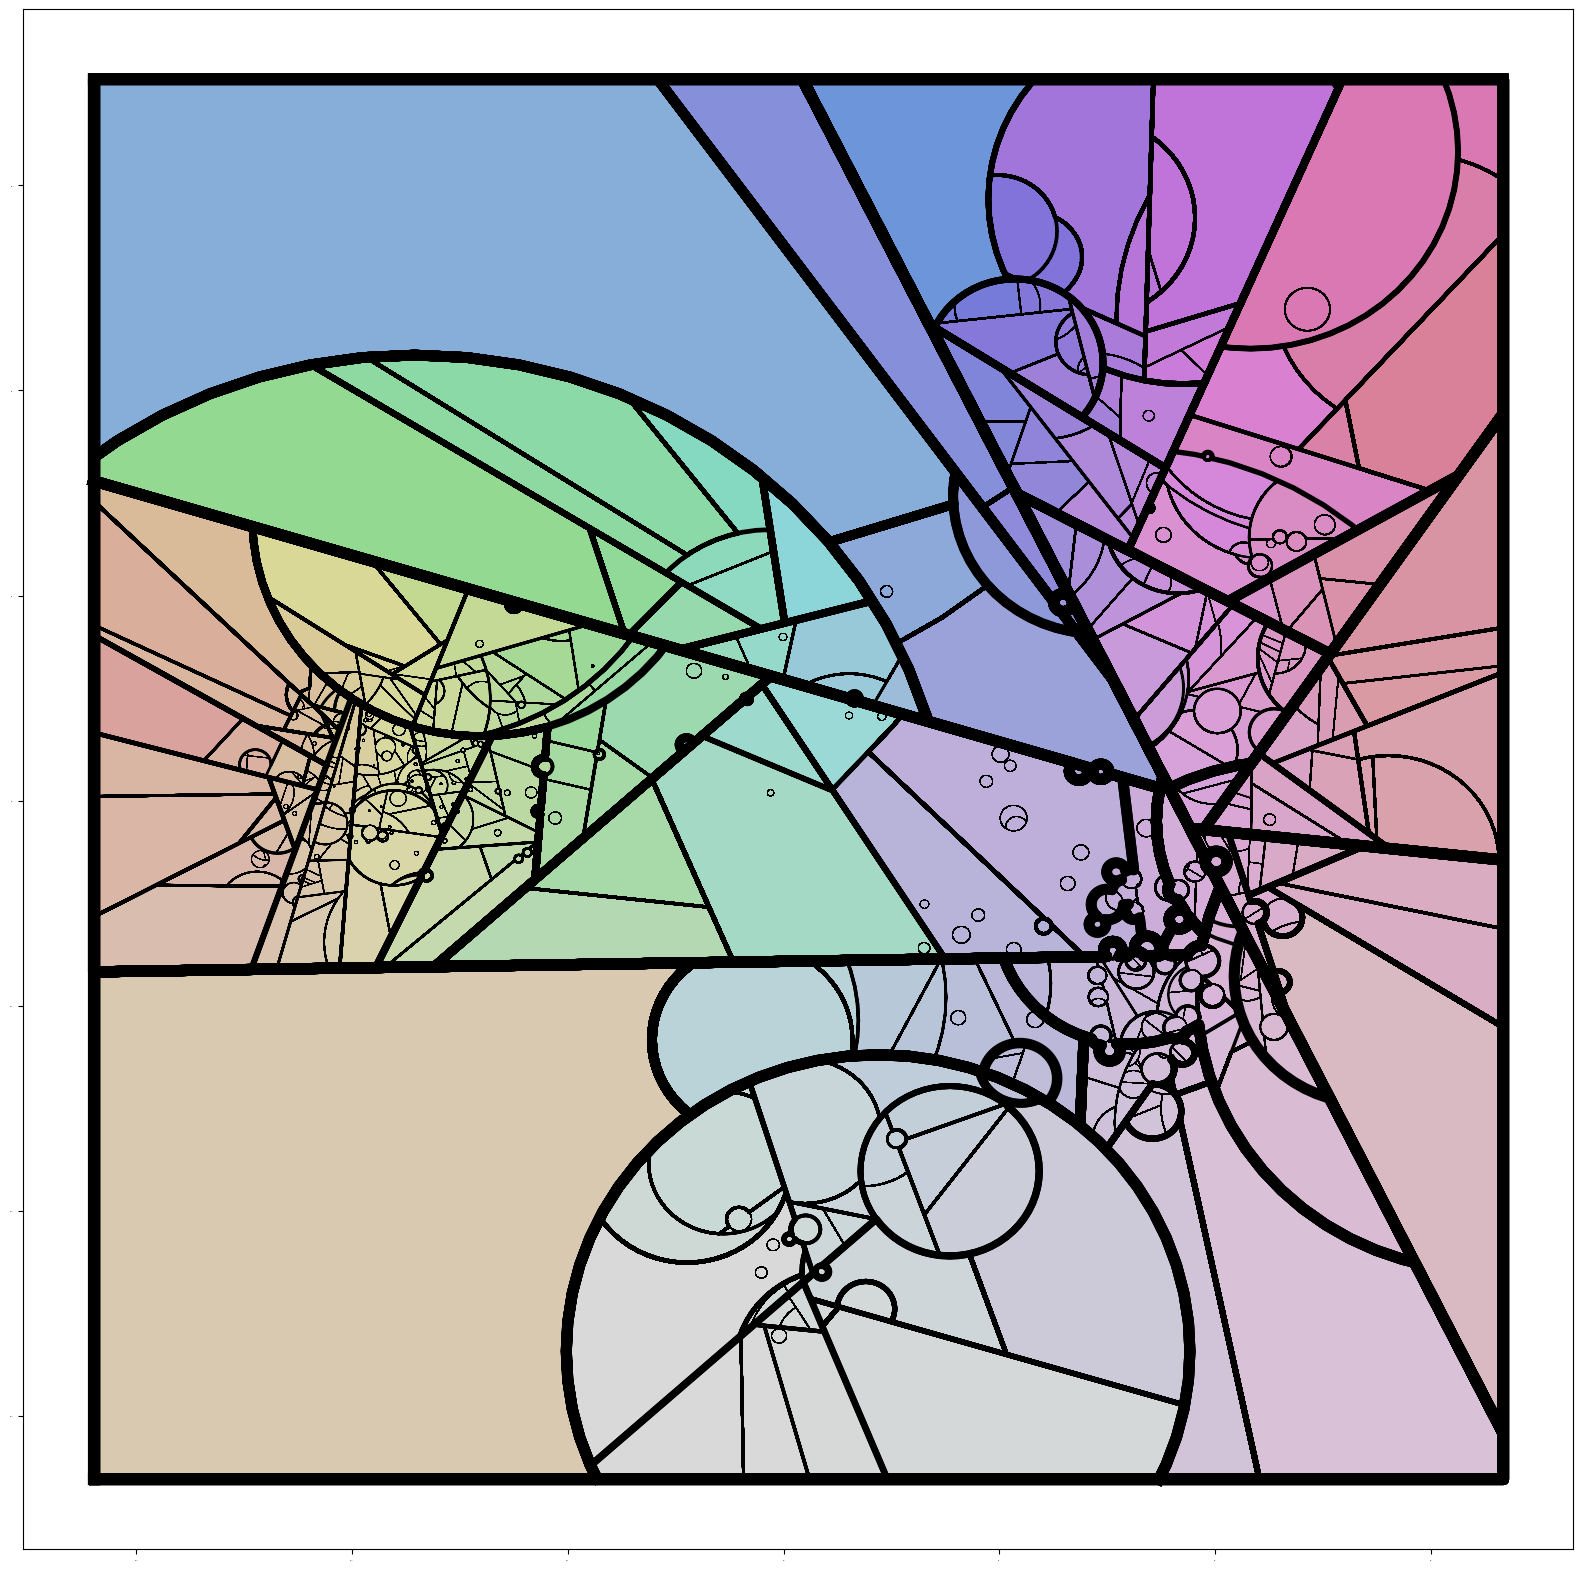

In [56]:
nested_weighted_voronoi(tree, bounding_box)

100% |###############################################################################################################################################################################################################|
/var/folders/ks/_0r_wl8s4qb7h__y99dz5c0r0000gn/T/ipykernel_64145/3271839100.py:23: UserWarning: Glyph 129504 (\N{BRAIN}) missing from current font.
  fig.savefig(outfile, dpi=1000) # The font has to be very small to be legible, requiring an extremely high-res image to zoom in on to read the labels
/var/folders/ks/_0r_wl8s4qb7h__y99dz5c0r0000gn/T/ipykernel_64145/3271839100.py:23: UserWarning: Glyph 128140 (\N{LOVE LETTER}) missing from current font.
  fig.savefig(outfile, dpi=1000) # The font has to be very small to be legible, requiring an extremely high-res image to zoom in on to read the labels


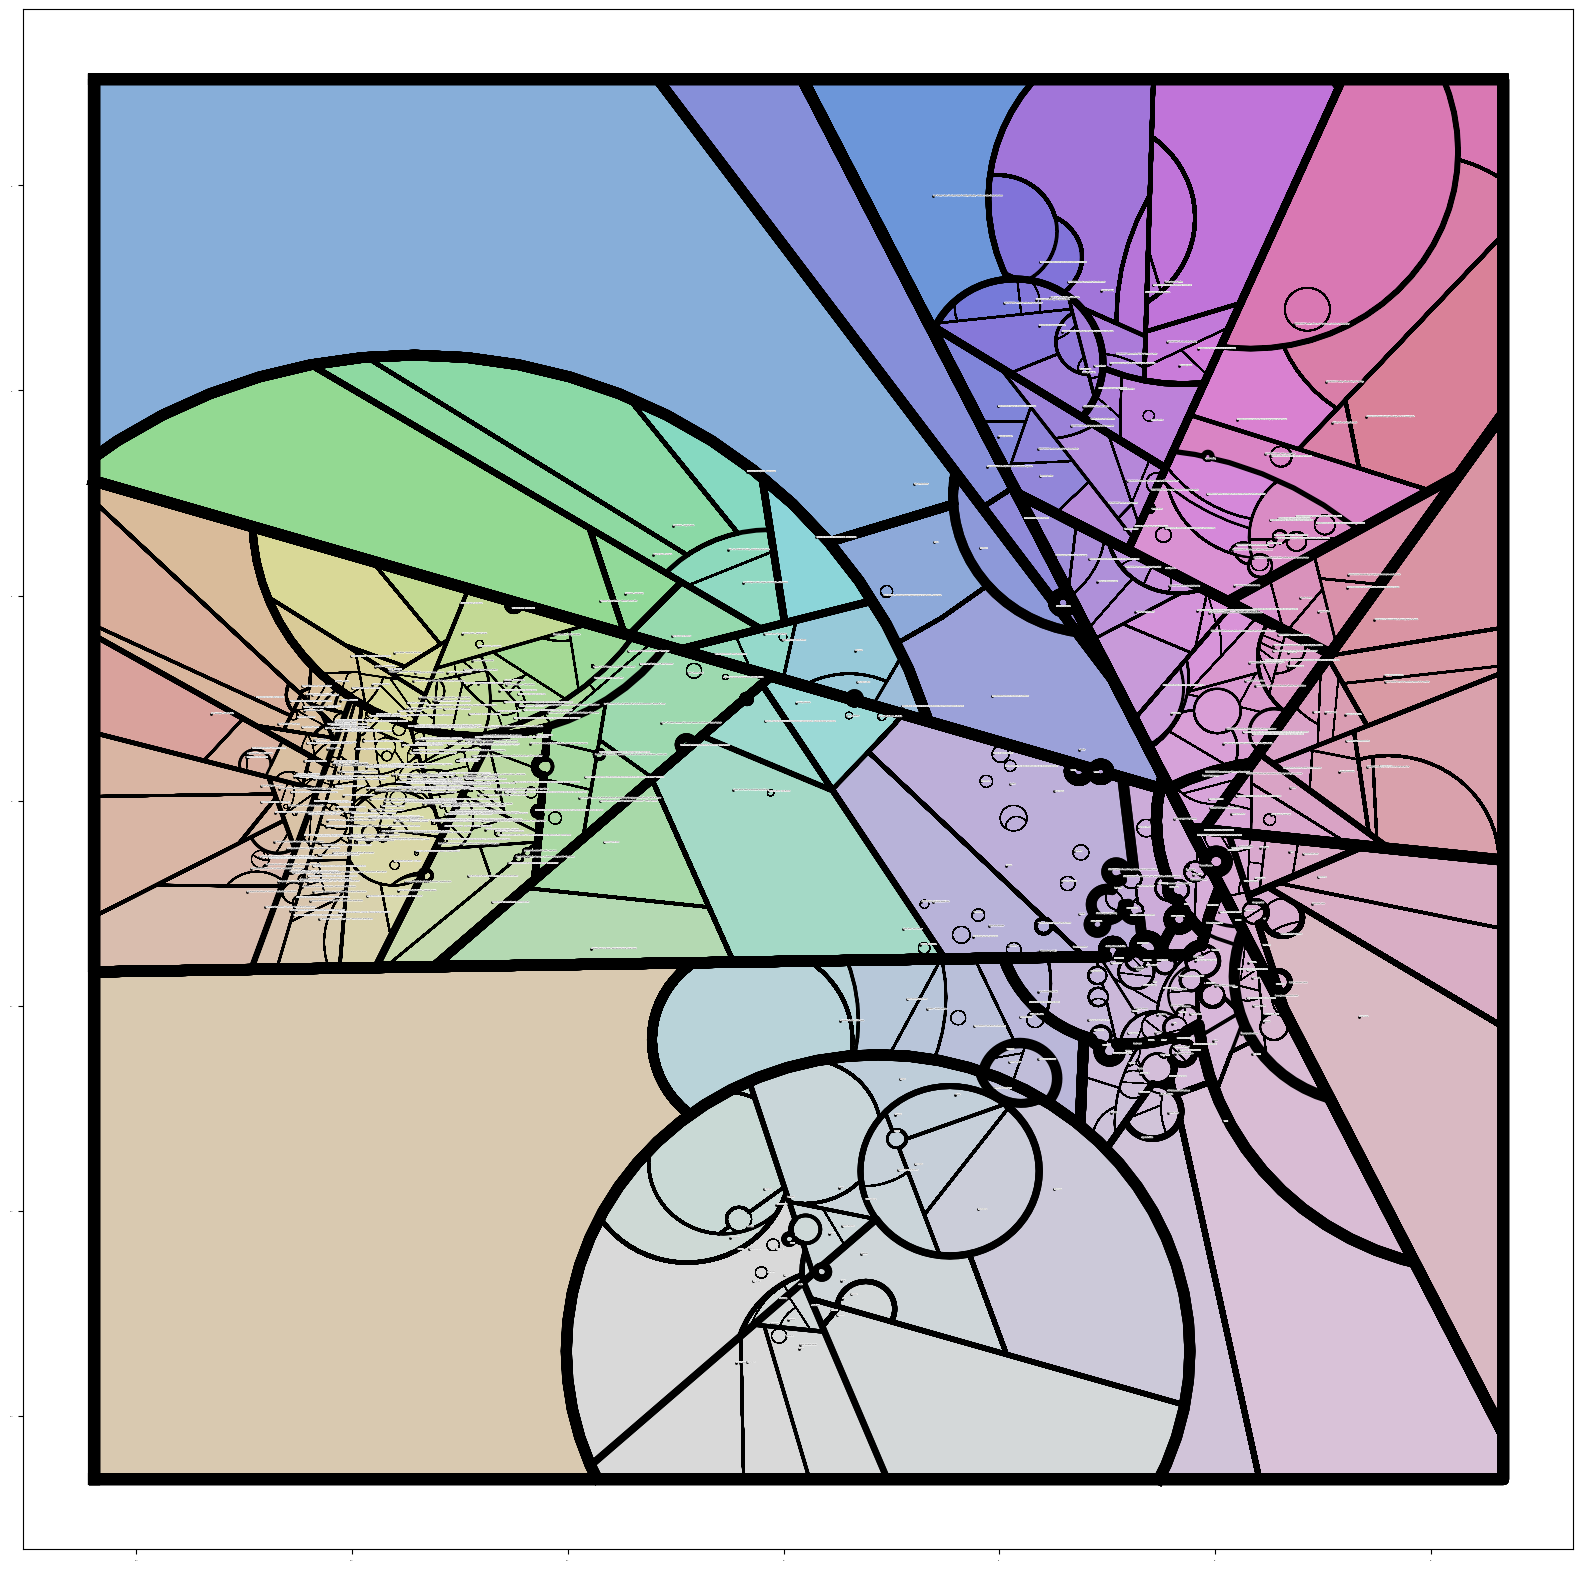

In [62]:
nested_weighted_voronoi(tree, bounding_box, labels=True, outfile='tesselation_labeled.png')